In [13]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import roc_auc_score
import sys
import numpy as np
import pandas as pd

import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.layers import Input, Embedding, Activation, Flatten, Dense
from keras.layers import Conv1D, MaxPooling1D, Dropout
from keras.models import Model, Sequential

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 8) 

In [14]:
def data():
    Train = pd.read_csv('../train_data_2.csv')[:300]
    Validation = pd.read_csv('../validation_data_2.csv')[:100]
    Test = pd.read_csv('../test_data_2.csv')[:100]

    #Train = pd.concat([Train, Validation])

    X_train, y_train = Train['tweet'], to_categorical(Train['class'])
    X_val, y_val = Validation['tweet'], to_categorical(Validation['class'])
    X_test, y_test   = Test['tweet'], to_categorical(Test['class'])

    train_texts = X_train.values
    train_texts = [s.lower() for s in train_texts]
    
    val_texts = X_val.values
    val_texts = [s.lower() for s in val_texts]

    test_texts = X_test.values
    test_texts = [s.lower() for s in test_texts]

    alphabet = "abcdefghijklmnopqrstuvwxyz0123456789,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"
    char_dict = {}
    for i, char in enumerate(alphabet):
        char_dict[char] = i + 1

    tk = Tokenizer(num_words=None, char_level=True, oov_token='UNK')
    tk.fit_on_texts(train_texts)
    tk.word_index = char_dict.copy()
    tk.word_index[tk.oov_token] = max(char_dict.values()) + 1

    train_sequences = tk.texts_to_sequences(train_texts)
    val_sequences = tk.texts_to_sequences(val_texts)
    test_sequences  = tk.texts_to_sequences(test_texts)

    # Padding
    train_data = pad_sequences(train_sequences, maxlen=200, padding='post')
    val_data = pad_sequences(val_sequences, maxlen=200, padding='post')
    test_data = pad_sequences(test_sequences, maxlen=200, padding='post')

    # Convert to numpy array
    x_train = np.array(train_data, dtype='float32')
    x_val = np.array(val_data,  dtype='float32')
    x_test  = np.array(test_data,  dtype='float32')
    
    # Create embedding
    char_vocab = len(tk.word_index)
    embedding_weights = []
    embedding_weights.append(np.zeros(char_vocab))

    for char, i in tk.word_index.items():
        onehot = np.zeros(char_vocab)
        onehot[i-1] = 1
        embedding_weights.append(onehot)
    embedding_weights = np.array(embedding_weights)
    
    embedding_size = embedding_weights.shape[1]
    input_size = train_data.shape[1]
    embedding_layer = Embedding(char_vocab+1,
                           embedding_size,
                           input_length=input_size,
                           weights=[embedding_weights])

    return x_train, y_train, x_test, y_test, x_val, y_val, embedding_layer

In [20]:
X_train, y_train, X_test, y_test, X_val, y_val, embedding_layer = data()

space = {
            'choice':   hp.choice('layers', [1, 2, 3, 4]),
            
            'pooling_size1': hp.choice('pooling_size1', [3]),
            'pooling_size2': hp.choice('pooling_size2', [3, -1]),
            'pooling_size3': hp.choice('pooling_size3', [3, -1]),
            'pooling_size4': hp.choice('pooling_size4', [3, -1]),
            'pooling_size5': hp.choice('pooling_size5', [3, -1]),
    
            'dropout1': hp.uniform('dropout1', .25,.75),
            'dropout2': hp.uniform('dropout2', .25,.75),
            'dropout3': hp.uniform('dropout3', .25,.75),
            'dropout4': hp.uniform('dropout4', .25,.75),
            'dropout5': hp.uniform('dropout5', .25,.75),
    
    
            'batch_size' : hp.choice('batch_size', [32, 64]),
            'hidden_activation': hp.choice('hidden_activation', ['relu', 'sigmoid', 'tanh', 'selu']),
            'optimizer': hp.choice('optimizer',['adadelta', 'adam', 'rmsprop']),
            'loss': hp.choice('loss', ['binary_crossentropy']), 
            'nb_epochs' :  15,
            'activation': 'relu',
            'patience': 10
        }

Params testing:                                      
[[256, 7], [256, 7], [256, 7], [256, 7]]             
val_accuracy: 0.890000                               
  0%|          | 0/5 [00:23<?, ?trial/s, best loss=?]

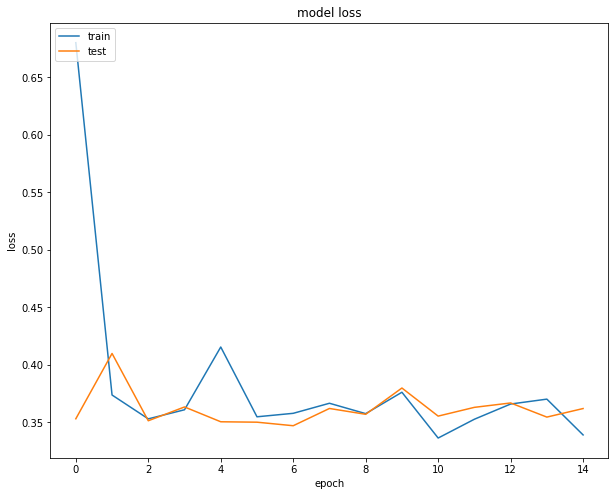

Params testing:                                                                 
[[256, 7], [256, 7], [256, 7]]                                                  
val_accuracy: 0.910000                                                          
 20%|██        | 1/5 [00:42<01:35, 23.89s/trial, best loss: -0.8899999856948853]

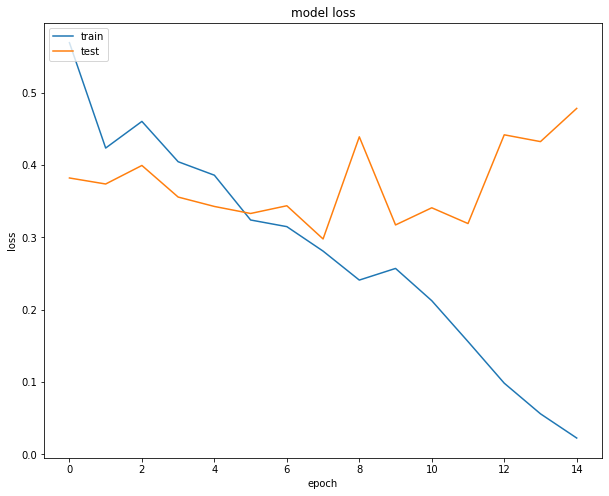

Params testing:                                                                 
[[256, 7], [256, 7], [256, 7], [256, 7]]                                        
val_accuracy: 0.890000                                                          
 40%|████      | 2/5 [01:11<01:07, 22.42s/trial, best loss: -0.9100000262260437]

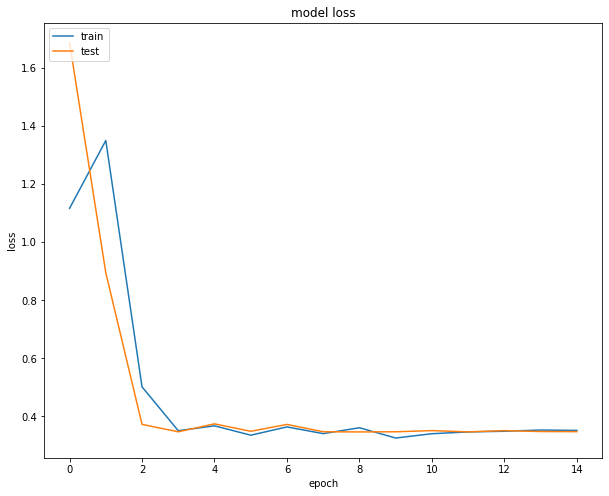

Params testing:                                                                 
[[256, 7]]                                                                      
val_accuracy: 0.890000                                                          
 60%|██████    | 3/5 [01:26<00:48, 24.27s/trial, best loss: -0.9100000262260437]

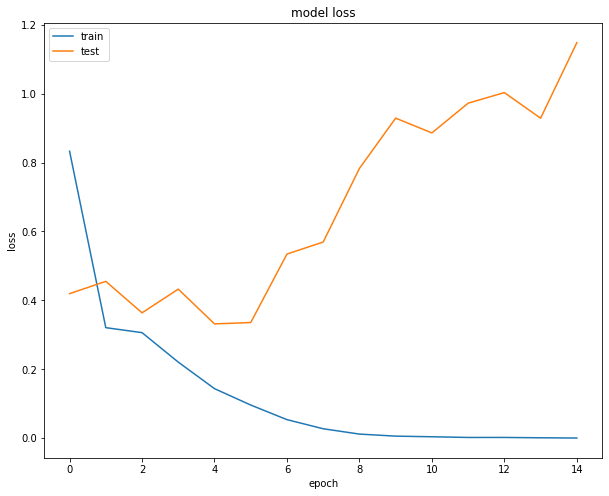

Params testing:                                                                 
[[256, 7], [256, 7], [256, 7], [256, 7]]                                        
val_accuracy: 0.890000                                                          
 80%|████████  | 4/5 [01:54<00:21, 21.48s/trial, best loss: -0.9100000262260437]

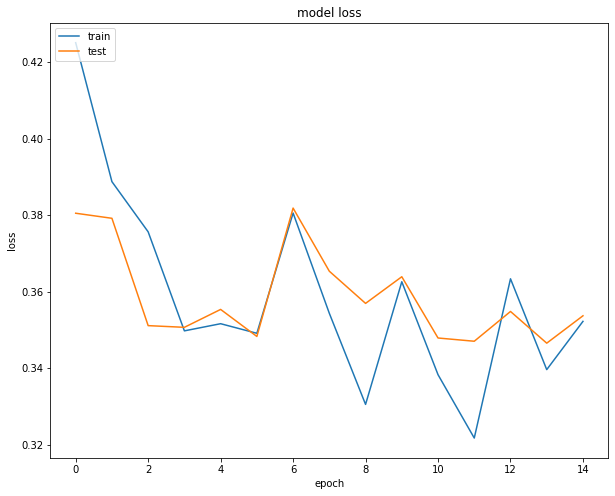

100%|██████████| 5/5 [01:54<00:00, 22.99s/trial, best loss: -0.9100000262260437]

 THE best: 
('batch_size', 1)
('dropout1', 0.6334371211063357)
('dropout2', 0.36283182783153534)
('dropout3', 0.6297297987936828)
('dropout4', 0.6357503507027977)
('dropout5', 0.36563410317891387)
('hidden_activation', 2)
('layers', 2)
('loss', 0)
('optimizer', 1)
('pooling_size1', 0)
('pooling_size2', 0)
('pooling_size3', 1)
('pooling_size4', 0)
('pooling_size5', 1)


In [21]:
def f_nn(params):   
    from keras.models import Sequential
    from keras.layers.core import Dense, Dropout, Activation
    from keras.optimizers import Adadelta, Adam, rmsprop
    from time import sleep
    
    # set parameters
    num_of_classes = 2
    fully_connected_layers = [200, 200] 
    
    conv = [256, 7] ##filter_num, filter_size
    if params['choice'] == 1: conv_layers = [conv]*1
    elif params['choice'] == 2: conv_layers = [conv]*2
    elif params['choice'] == 3: conv_layers = [conv]*3
    else: conv_layers = [conv]*4 
    
    sys.stdout.flush() 
    print ('Params testing: ')
    #for parameter in params: print((parameter, params[parameter]))
    
    # build model
    inputs = Input(shape=(X_train.shape[1],), name='input', dtype='int64')
    x = embedding_layer(inputs)
    print(conv_layers)
    for i, cv in enumerate(conv_layers):
        filter_num, filter_size = cv[0], cv[1]
        x = Conv1D(filter_num, filter_size)(x)
        x = Activation(params['hidden_activation'])(x)
        if params['pooling_size'+str(i+1)] != -1:
            x = MaxPooling1D(pool_size=params['pooling_size'+str(i+1)])(x)
    x = Flatten()(x)
    for i, dense_size in enumerate(fully_connected_layers):
        x = Dense(dense_size, activation='relu')(x)
        x = Dropout(params['dropout'+str(i+1)])(x)
    predictions = Dense(num_of_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss      = params['loss'], 
                  optimizer = params['optimizer'], 
                  metrics   = ['acc'])
    #model.summary()
    
    # prepare checkpoints
    STAMP = 'CNN_hyperopt'
    patience = params['patience']
    early_stopping =EarlyStopping(monitor='val_loss', patience=patience)
    bst_model_path = STAMP + '.h5'
    model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)
    
    # fit model
    history = model.fit(X_train, y_train, 
              validation_data=(X_val, y_val),
              nb_epoch=params['nb_epochs'], 
              batch_size=params['batch_size'], 
              verbose = 0, callbacks=[early_stopping, model_checkpoint])
    
    acc = np.amax(history.history['val_acc'])
    print(f'val_accuracy: {acc:.6f}')
    sys.stdout.flush() 

    # summarize history for accuracy
#     plt.plot(history.history['acc'])
#     plt.plot(history.history['val_acc'])
#     plt.title('model accuracy')
#     plt.ylabel('acc')
#     plt.xlabel('epoch')
#     plt.legend(['train', 'test'], loc='upper left')
#     plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    sys.stdout.flush()
    
    return {'loss': -acc, 'status': STATUS_OK}


trials = Trials()
best = fmin(f_nn, space, algo=tpe.suggest, max_evals=5, trials=trials)
print('\n THE best: ')

for parameter in best: print((parameter, best[parameter]))

In [31]:
batch_size = 64

dropout1 = 0.6334371211063357
dropout2 = 0.36283182783153534
dropout3 = 0.6297297987936828
dropout4 = 0.6357503507027977
dropout5 = 0.36563410317891387

hidden_activation = 'tanh'
layers = 3
loss = 'binary_crossentropy'
optimizer = 'adam'

pooling_size1 = 3
pooling_size2 = 3
pooling_size3 = -1
pooling_size4 = 3
pooling_size5 = -3

In [32]:
model

NameError: name 'model' is not defined